In [1]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
from imblearn.under_sampling import RandomUnderSampler
from keras.optimizers import SGD,Adam
from datetime import datetime
maintenant = datetime.now()
print(maintenant)
import tensorflow as tf


gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



#from tensorflow.keras.datasets.mnist import load_data # Pour charger le dataset MNIST
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense # Pour construire un réseau de neurones et
                                                 # instancier une couche d'entrée et une couche den
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
import matplotlib.pyplot as plt
import os
import cv2
import gc
import itertools # Pour créer des itérateurs
import pickle

2024-02-06 21:47:51.946943
1 Physical GPUs, 1 Logical GPUs


In [2]:
SUFFIXE_FICHIER = "EfficientNetB1_V01"
STRATEGIE = "sampling_strategy_B1_V01.csv"
IMGSIZE       = 400    # Taille de l'image en input
EPOCH         = 20     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 333    # pour un EfficientNetB1 freeze de réapprentissage de certaines couches
NB_PAR_LABEL_MAX = 5000 # nombre maximun d'enregistrement par label = undersampling
NB_PAR_LABEL_MIN = 2000 # nombre maximun d'enregistrement par label = undersampling
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('../src')
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/src')
#!pip install -r /content/drive/MyDrive/Colab Notebooks/requirements.txt

In [4]:
import Bibli_DataScience_3_2 as ds
import CNN_DataScience_2 as cnn

E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/input/
E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/
section :  ['DOSSIER', 'FICHIER']


In [39]:
# Pour recharger si nesséssaire
import imp
imp.reload(ds)
imp.reload(cnn)

E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/input/
E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/
section :  ['DOSSIER', 'FICHIER']


<module 'CNN_DataScience_2' from 'E:\\Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/src\\CNN_DataScience_2.py'>

In [5]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
#cat=df_target['prdtypecode'].sort_values().unique()
nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
Lcat

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

In [6]:
df['nom_image']=df.apply(lambda row: "image_" +  str(row['imageid']) 
                                     + "_product_" + str(row['productid']) + ".jpg",axis=1)
print("Nb enreg ", str(df.shape[0]))
print(df.head(5))
df_img=df.copy()

Nb enreg  84916
   Id                                        designation  \
0   0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1   1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2   2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3   3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4   4                               La Guerre Des Tuques   

                                         description   productid     imageid  \
0                                                NaN  3804725264  1263597046   
1                                                NaN   436067568  1008141237   
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
3                                                NaN    50418756   457047496   
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786   

   prdtypecode                                nom_image  
0           10  image_1263597046_product_3804725264.jpg  
1         2280   image_100

In [7]:
folder_path = ds.get_RACINE_IMAGES() 
print(folder_path)
df['filepath']=df['nom_image'].apply(lambda x : os.path.join(folder_path, x))

E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/


## test de lecture d'image¶

E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1263597046_product_3804725264.jpg


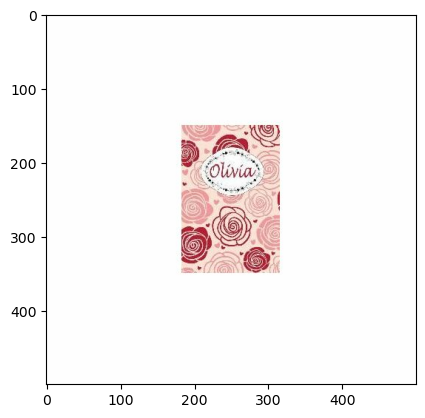

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Chemin de l'image
filename = df.nom_image[0]
filepath = os.path.join(folder_path, filename)
print(filepath)
# Lecture du fichier
im = tf.io.read_file(filepath)

# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)

# Affichage du tensor
plt.imshow(im);

## REDIMENSIONNEMENT

In [9]:
filepath = df.filepath[0]
# Lecture du fichier
im = tf.io.read_file(filepath)
# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)
# Redimensionnement
tf.image.resize(im, size=(IMGSIZE,IMGSIZE))


<tf.Tensor: shape=(400, 400, 3), dtype=float32, numpy=
array([[[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       ...,

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 25

In [10]:
y_serie =pd.Series(df.prdtypecode).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64

In [11]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] > NB_PAR_LABEL_MAX:
    sampling_strategy[key] = NB_PAR_LABEL_MAX
del y_serie,new_class_counts
#print(type(sampling_strategy))
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)
sampling_strategy

{2583: 5000,
 1560: 5000,
 1300: 5000,
 2060: 4993,
 2522: 4989,
 1280: 4870,
 2403: 4774,
 2280: 4760,
 1920: 4303,
 1160: 3953,
 1320: 3241,
 10: 3116,
 2705: 2761,
 1140: 2671,
 2582: 2589,
 40: 2508,
 2585: 2496,
 1302: 2491,
 1281: 2070,
 50: 1681,
 2462: 1421,
 2905: 872,
 60: 832,
 2220: 824,
 1301: 807,
 1940: 803,
 1180: 764}

In [12]:
print(df.filepath.shape)
print(df.prdtypecode.shape)
X=np.array(df.filepath)
y=np.array(df.prdtypecode)
X=X.reshape(-1,1)
y=y.reshape(-1,1)
X.shape

(84916,)
(84916,)


(84916, 1)

In [13]:

rUs = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_ru, y_ru = rUs.fit_resample(X, y  )
#del   X_Reshape, y
#gc.collect()
print(len(X_ru))
print(len(X_ru))

79589
79589


In [14]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train_ru, X_test_path, y_train_ru, y_test = train_test_split(X_ru, y_ru, train_size=0.8, random_state=1234,
                                                              stratify=y_ru,shuffle=True)

In [15]:
y_serie =pd.Series(y_train_ru).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

1560


1560    4000
1300    4000
2583    4000
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

	Categorie	Qunatity	predict	pourc	predict2	pourc2	predict3	pourc3
0	2583	6000	2583	0.867500	2585	0.020000	1302	0.015833
1	1560	5073	1560	0.686700	2060	0.063054	2582	0.056158
2	1300	5045	1300	0.809713	1280	0.068385	50	0.021804
3	2060	4993	2060	0.528529	1560	0.089089	1920	0.057057
4	2522	4989	2522	0.732465	2583	0.034068	2060	0.027054
5	1280	4870	1280	0.442505	1300	0.171458	1140	0.079055
6	2403	4774	2403	0.705759	2280	0.129843	10	0.068063
7	2280	4760	2280	0.831933	2403	0.066176	10	0.043067
8	1920	4303	1920	0.845528	1560	0.048780	2060	0.025552
9	1160	3953	1160	0.939317	2403	0.013906	40	0.010114
10	1320	3241	1320	0.518519	1560	0.087963	1280	0.086420
11	10	    3116	10	0.624398	2280	0.102729	2403	0.096308
12	2705	2761	2705	0.902174	10	0.038043	2280	0.025362
13	1140	2671	1140	0.681648	1280	0.093633	1300	0.026217
14	2582	2589	2582	0.415058	1560	0.206564	2060	0.100386
15	40	    2508	40	0.613546	50	0.047809	2905	0.037849
16	2585	2496	2585	0.488978	2583	0.126253	1300	0.080160
17	1302	2491	1302	0.475904	1280	0.154618	1320	0.058233
18	1281	2070	1281	0.236715	1280	0.231884	2403	0.079710
19	50	    1681	50	    0.482143	1300	0.086310	60	0.059524
20	2462	1421    2462	0.598592	40	0.137324	2403	0.066901
21	2905	872	    2905	0.913793	2705	0.022989	10	0.022989
22	60	    832	    60	    0.777108	2462	0.066265	1281	0.030120
23	2220	824	    2220	0.387879	2583	0.096970	1280	0.090909
24	1301	807	   1301	    0.683230	1300	0.043478	2583	0.037267
25	1940	803	   1940	    0.795031	2583	0.062112	2403	0.031056
26	1180	764	   1180	    0.366013	1140	0.098039	1280	0.071895

In [16]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] <NB_PAR_LABEL_MIN :
  #if key in [1180,2220]:  
    sampling_strategy[key] = NB_PAR_LABEL_MIN
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)    
sampling_strategy

{1560: 4000,
 1300: 4000,
 2583: 4000,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 2000,
 1302: 2000,
 1281: 2000,
 50: 2000,
 2462: 2000,
 2905: 2000,
 60: 2000,
 2220: 2000,
 1301: 2000,
 1940: 2000,
 1180: 2000}

In [17]:
from imblearn.over_sampling import RandomOverSampler
rOs = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_path, y_train = rOs.fit_resample(X_train_ru, y_train_ru)

In [18]:
y_res_series = pd.Series(y_train).value_counts()
print(y_res_series)


1560    4000
1300    4000
2583    4000
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
1281    2000
1301    2000
2905    2000
1302    2000
1940    2000
2462    2000
1180    2000
2220    2000
50      2000
2585    2000
60      2000
Name: count, dtype: int64


In [19]:

X_train_path=X_train_path.reshape(-1,)
print(X_train_path.shape)
X_test_path=X_test_path.reshape(-1,)
print(X_test_path.shape)

(73621,)
(15918,)


In [20]:


with open(ds.get_RACINE_SAUVEGARDE() + 'X_train_path.pkl', 'wb') as f:
    pickle.dump(X_train_path, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'X_test_path.pkl', 'wb') as f:
    pickle.dump(X_test_path, f)

In [21]:
print(X_train_path[:2])
print(y_train[:2])
print(X_test_path[:2])
print(y_test[:2])

['E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1121142483_product_2031748912.jpg'
 'E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1083016177_product_1475390024.jpg']
[1280 2403]
['E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1247849637_product_3813571357.jpg'
 'E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1316317272_product_4209030564.jpg']
[2583 1920]


In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

(73621, 27)
(15918, 27)


In [23]:
print(y_train_Network[:2])


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0.]]


In [23]:

@tf.function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    #image = tf.image.rot90(image, k=1) 
    image = tf.image.random_crop(image,[400, 400, 3])
    return image



@tf.function
def load_and_augment_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = augment_image(image)
    return tf.image.resize(image, resize)

@tf.function
def load_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network ))

dataset_train = dataset_train.map(lambda x, y : [load_and_augment_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)
#dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

#dataset_train_aug = tf.data.Dataset.from_tensor_slices((X_train_path_aug, y_train_Network_aug))
#dataset_train_aug = dataset_train_aug.map(lambda x, y: [load_and_augment_image2(x), y], num_parallel_calls=-1).batch(32)



0 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1121142483_product_2031748912.jpg
1 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1083016177_product_1475390024.jpg
2 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1273195785_product_3992410033.jpg
3 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_937054301_product_197231532.jpg
4 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1109639872_product_1847458103.jpg


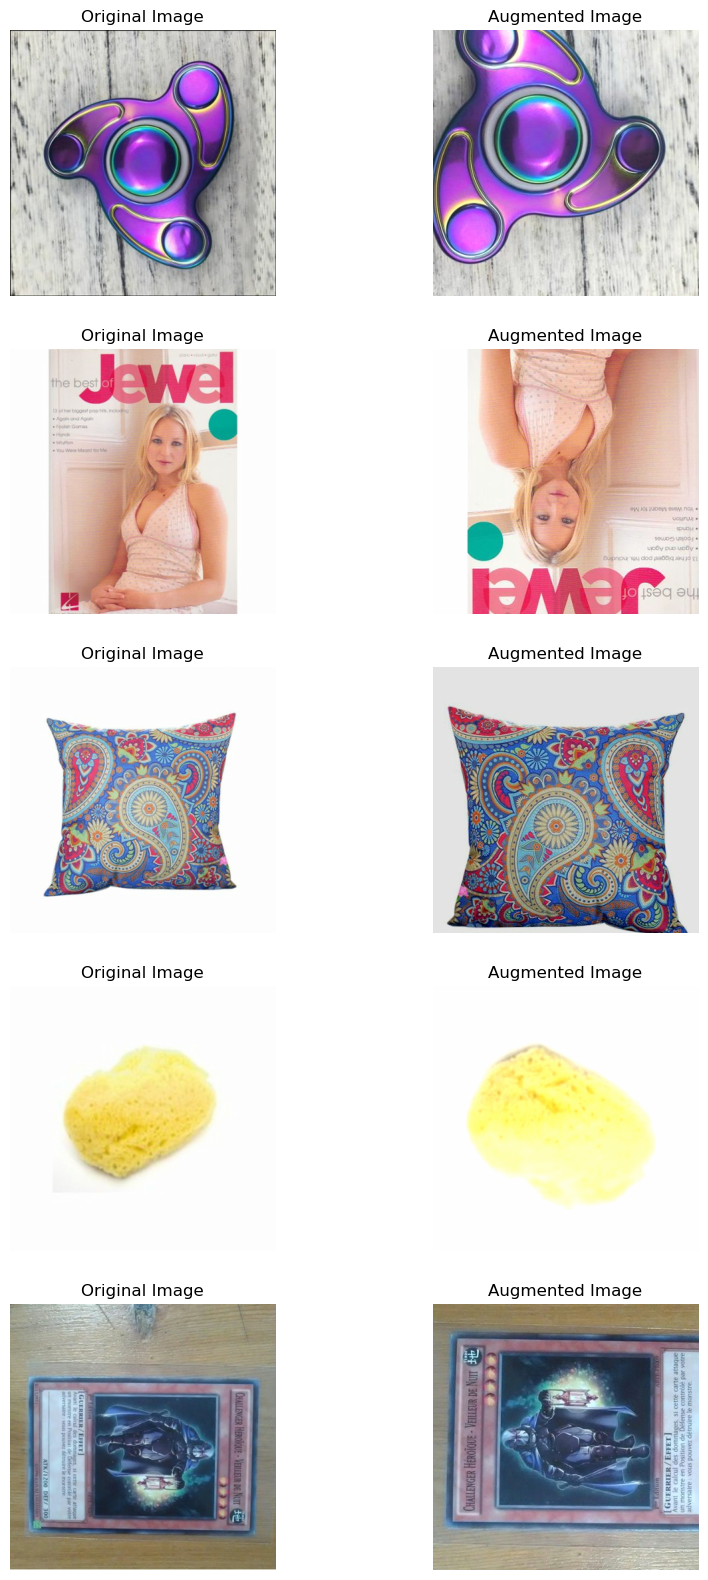

In [24]:
random_samples = X_train_path[:5]

# Créer une figure pour afficher les images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, nom in enumerate(random_samples):
    print(i, nom)
    # Charger l'image originale
    original_image = load_image(nom)/255.0

    # Redimensionner l'image pour l'affichage
    #resized_image = tf.image.resize(original_image, (IMGSIZE, IMGSIZE))

    # Charger l'image à l'aide de la fonction load_image
    augmented_image = load_and_augment_image(nom)/255.0

    # Afficher l'image originale et l'image augmentée
    axs[i, 0].imshow(original_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(augmented_image)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Augmented Image')

plt.show()



@tf.function
def load_image(filepath, resize=(500,500)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network))

dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(32)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(32)



In [25]:
from tensorflow.keras.applications import EfficientNetB1

# Chargement du modèle efficientNet
base_model = EfficientNetB1(include_top=False, weights='imagenet',input_shape=(IMGSIZE,IMGSIZE,3))

for layer in base_model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
    
# Entrainement des derniers layers de classification
for layer in base_model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 400, 400, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 400, 400, 3)  0           ['normalization[0][0

 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 25, 25, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_add (Add)              (None, 25, 25, 112)  0           ['block5c_drop[0][0]',           
                                                                  'block5b_add[0][0]']            
                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 25, 25, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 25, 25, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization) 

 block6b_expand_conv (Conv2D)   (None, 13, 13, 1152  221184      ['block6a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 13, 13, 1152  4608       ['block6b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6b_expand_activation (Act  (None, 13, 13, 1152  0          ['block6b_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 13, 13, 1152  28800      ['block6b_expand_activation[0][0]
 D)       

 block6d_expand_bn (BatchNormal  (None, 13, 13, 1152  4608       ['block6d_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6d_expand_activation (Act  (None, 13, 13, 1152  0          ['block6d_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6d_dwconv (DepthwiseConv2  (None, 13, 13, 1152  28800      ['block6d_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 13, 13, 1152  4608       ['block6d_dwconv[0][0]']         
 )        

 block7a_expand_activation (Act  (None, 13, 13, 1152  0          ['block7a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 13, 13, 1152  10368      ['block7a_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 13, 13, 1152  4608       ['block7a_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block7a_activation (Activation  (None, 13, 13, 1152  0          ['block7a_bn[0][0]']             
 )        

del training_history
gc.collect()

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

noms_de_colonnes = ['Lrate', 'NbNeurones_Layer1', 'NbNeurones_Layer2','Dropout','Accuracy','Loss','Val_accuracy','Val_loss']

df_reseaux = pd.DataFrame(columns=noms_de_colonnes)

for lrate in  [1e-5,5e-6,1e-6]:
    for niv1 in [1024,512,128]:
        for dprout in [0.10,0.20,0.30]:
            print("=====================  Adam   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1,niv1//2)
            print('dprout = ' ,dprout)
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1//2, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            model.compile(optimizer=Adam(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
            #print(model.summary())
            training_history = model.fit(dataset_train, epochs=2, validation_data = dataset_test)
            train_acc = training_history.history['accuracy']
            val_acc = training_history.history['val_accuracy']
            tloss = training_history.history['loss']
            tvalloss=training_history.history['val_loss']
            df_reseaux.loc[len(df_reseaux)] = [lrate, niv1,niv1//2, dprout,train_acc,tloss,val_acc,tvalloss]
            del training_history
            gc.collect()
            print("=====================  SGD   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1,niv1//2)
            print('dprout = ' ,dprout)
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1//2, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            model.compile(optimizer=SGD(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
            training_history = model.fit(dataset_train, epochs=2, validation_data = dataset_test)
            train_acc = training_history.history['accuracy']
            val_acc = training_history.history['val_accuracy']
            tloss = training_history.history['loss']
            tvalloss=training_history.history['val_loss']
            df_reseaux.loc[len(df_reseaux)] = [lrate, niv1,n1v1//2, dprout,train_acc,tloss,val_acc,tvalloss]
            del training_history
            gc.collect()
            print("=========================================================")
            print(df_reseaux)
            

=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.1
Epoch 1/2
2301/2301 [==============================] - 936s 404ms/step - loss: 2.0961 - accuracy: 0.4289 - val_loss: 3.0000 - val_accuracy: 0.2397
Epoch 2/2
2301/2301 [==============================] - 976s 424ms/step - loss: 1.6933 - accuracy: 0.5169 - val_loss: 2.6935 - val_accuracy: 0.3000
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.1
Epoch 1/2
2301/2301 [==============================] - 802s 346ms/step - loss: 3.6402 - accuracy: 0.0650 - val_loss: 3.1026 - val_accuracy: 0.1630
Epoch 2/2
1111/2301 [=============>................] - ETA: 5:49 - loss: 3.2373 - accuracy: 0.1385

In [16]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
for lrate in [1e-5,5e-6,1e-6]:
    for niv1 in [512,1024]:
        for dprout in [0.10,0.20,0.30]:
            print("=====================  Adam   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1)
            print('dprout = ' ,dprout)
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            model.compile(optimizer=Adam(lr=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
            training_history = model.fit(dataset_train, epochs=3, validation_data = dataset_test)
            print("=====================  SGD   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1)
            print('dprout = ' ,dprout)
            del model
            gc.collect()
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            model.compile(optimizer=SGD(lr=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
            training_history = model.fit(dataset_train, epochs=3, validation_data = dataset_test)
            
            print("=========================================================")
            

=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  512
dprout =  0.1


E:\Users\shaky\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
2018/2018 [==============================] - 1036s 458ms/step - loss: 3.1757 - accuracy: 0.0631 - val_loss: 3.1478 - val_accuracy: 0.0629
Epoch 2/3
2018/2018 [==============================] - 843s 418ms/step - loss: 3.1510 - accuracy: 0.0675 - val_loss: 3.1358 - val_accuracy: 0.0803
Epoch 3/3
2018/2018 [==============================] - 876s 434ms/step - loss: 3.1443 - accuracy: 0.0718 - val_loss: 3.1299 - val_accuracy: 0.0781
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  512
dprout =  0.1
Epoch 1/3


E:\Users\shaky\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2018/2018 [==============================] - 851s 418ms/step - loss: 3.1800 - accuracy: 0.0610 - val_loss: 3.1369 - val_accuracy: 0.0601
Epoch 2/3
2018/2018 [==============================] - 854s 423ms/step - loss: 3.1583 - accuracy: 0.0643 - val_loss: 3.1351 - val_accuracy: 0.0743
Epoch 3/3
2018/2018 [==============================] - 846s 419ms/step - loss: 3.1524 - accuracy: 0.0656 - val_loss: 3.1348 - val_accuracy: 0.0745
=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.1
Epoch 1/3
2018/2018 [==============================] - 928s 456ms/step - loss: 3.1707 - accuracy: 0.0651 - val_loss: 3.1460 - val_accuracy: 0.0743
Epoch 2/3
2018/2018 [==============================] - 904s 448ms/step - loss: 3.1469 - accuracy: 0.0685 - val_loss: 3.1395 - val_accuracy: 0.0752
Epoch 3/3
2018/2018 [==============================] - 915s 453ms/step - loss: 3.1411 - accurac

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

In [27]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
model = Sequential()
model.add(base_model) # Ajout du modèle EfficientB1
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 13, 13, 1280)     6575239   
                                                                 
 flatten (Flatten)           (None, 216320)            0         
                                                                 
 dropout (Dropout)           (None, 216320)            0         
                                                                 
 dense (Dense)               (None, 1024)              221512704 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                        

In [28]:
#model.compile('sgd', 'sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile('sgd', 'categorical_crossentropy', metrics=['accuracy'])
#model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer =  SGD(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

E:\Users\shaky\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [26]:
print(SUFFIXE_FICHIER)
NBETAPE=6

for i in range(1,NBETAPE+1):
    print(i)
    saveweights = 'E:\\Manuel\\PROJET\\fichiers\\'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.h5'
    print(saveweights)
    trainacc  = 'E:\\Manuel\\PROJET\\fichiers\\train_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valacc = 'E:\\Manuel\\PROJET\\fichiers\\val_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    loss = 'E:\\Manuel\\PROJET\\fichiers\\loss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valloss = 'E:\\Manuel\\PROJET\\fichiers\\valloss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    print(trainacc)
    print(valacc)
    print(loss)
    print(valloss)
    dfpredict = 'df_predict_'+SUFFIXE_FICHIER+'_DeFreeze.csv'
    print(dfpredict)
    testoriginal = 'E:\\Manuel\\PROJET\\fichiers\\y_test_original2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    print(testoriginal)
    predoriginal = 'E:\\Manuel\\PROJET\\fichiers\\test_pred_orinal2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    print(predoriginal)

In [59]:
from tensorflow.keras import callbacks
NBETAPE=6
# Savegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath='E:\\Manuel\\PROJET\\fichiers\\checkpoint_B1_V4.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')

# Réduction automatique du taux d'apprentissage
"""
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=5,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min')
"""

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')


#model.fit(X_train, y_train, epochs=100, callbacks=[stall_stop])

#WEfficientNetB1_weights -> WEfficientNetB1_weights_1   50-50
#WEfficientNetB1_weights_1 -> WEfficientNetB1_weights_2  50-50  stoppé à 0.49
#WEfficientNetB1_weights_3 -> WEfficientNetB1_weights_4 40-40  
#model.load_weights('E:\\Manuel\\PROJET\\fichiers\\WEfficientNetB1_weights_V1.h5')

#model.fit(dataset_train, epochs=10, validation_data=(X_test, y_test_Network), callbacks=[lr_plateau, checkpoint])
#model.fit(dataset_train, epochs=10, validation_data=(X_test, y_test_Network))
for i in range(1,NBETAPE+1):
    print("tour : ==========  " ,i)
    saveweights = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.h5'
    trainacc  = ds.get_RACINE_SAUVEGARDE()+'train_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valacc = ds.get_RACINE_SAUVEGARDE()+'val_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    loss = ds.get_RACINE_SAUVEGARDE()+'loss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valloss = ds.get_RACINE_SAUVEGARDE()+'valloss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    dfpredict = ds.get_RACINE_SAUVEGARDE()+ 'df_predict_'+SUFFIXE_FICHIER+'_DeFreeze.csv'
    testoriginal = ds.get_RACINE_SAUVEGARDE()+'y_test_original2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    predoriginal = ds.get_RACINE_SAUVEGARDE()+'test_pred_orinal2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    training_history = model.fit(dataset_train, epochs=10, validation_data = dataset_test, callbacks=[lr_plateau])

    model.save_weights(saveweights)

    train_acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    tloss = training_history.history['loss']
    tvalloss=training_history.history['val_loss']
    with open(trainacc, 'wb') as f:
        pickle.dump(train_acc, f)
    with open(valacc, 'wb') as f:
        pickle.dump(val_acc, f)
    with open(loss, 'wb') as f:
        pickle.dump(tloss, f)
    with open(valloss, 'wb') as f:
        pickle.dump(tvalloss, f)
    
    y_test_original = np.argmax(y_test_Network, axis=1)
    #print(y_test_Network[0])
    y_test_original2=label_encoder.inverse_transform(y_test_original)

    predictions = model.predict(dataset_test)
    y_pred = np.argmax(predictions, axis=1)
    test_pred_orinal2=label_encoder.inverse_transform(y_pred)

    top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_orinal2})

    df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

    df_pred = pd.DataFrame()
    for c in Lcat:
        s = df_cross.loc[c].sort_values(ascending=False)[:5]
        df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
        df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    
    df_pred.to_csv(dfpredict)
    with open(testoriginal, 'wb') as f:
        pickle.dump(y_test_original2, f)
    with open(predoriginal, 'wb') as f:
        pickle.dump(test_pred_orinal2, f)

tour : ==========   1
Epoch 1/10
2301/2301 [==============================] - 1138s 491ms/step - loss: 2.3977 - accuracy: 0.3615 - val_loss: 2.3932 - val_accuracy: 0.3490 - lr: 1.0000e-05
Epoch 2/10
2301/2301 [==============================] - 940s 408ms/step - loss: 1.9705 - accuracy: 0.4512 - val_loss: 2.2536 - val_accuracy: 0.3825 - lr: 1.0000e-05
Epoch 3/10
2301/2301 [==============================] - 928s 403ms/step - loss: 1.7718 - accuracy: 0.4968 - val_loss: 2.1687 - val_accuracy: 0.4042 - lr: 1.0000e-05
Epoch 4/10
2301/2301 [==============================] - 1010s 439ms/step - loss: 1.6367 - accuracy: 0.5282 - val_loss: 2.1008 - val_accuracy: 0.4256 - lr: 1.0000e-05
Epoch 5/10
2301/2301 [==============================] - 1011s 439ms/step - loss: 1.5252 - accuracy: 0.5563 - val_loss: 2.0927 - val_accuracy: 0.4330 - lr: 1.0000e-05
Epoch 6/10
2301/2301 [==============================] - 1024s 445ms/step - loss: 1.4298 - accuracy: 0.5796 - val_loss: 2.0297 - val_accuracy: 0.4497 -

In [29]:
NBETAPE=6
for i in range(1,NBETAPE+1):   
    trainacc  = ds.get_RACINE_SAUVEGARDE() +'train_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valacc = ds.get_RACINE_SAUVEGARDE() +'val_acc_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    loss = ds.get_RACINE_SAUVEGARDE() +'loss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    valloss = ds.get_RACINE_SAUVEGARDE() +'valloss_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    testoriginal = ds.get_RACINE_SAUVEGARDE() +'y_test_original2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    predoriginal = ds.get_RACINE_SAUVEGARDE() +'test_pred_orinal2_'+SUFFIXE_FICHIER+'_weights_V4_DeFreeze_'+ str(i) + '.pkl'
    if i == 1:
        with open(trainacc, 'rb') as f:
            train_acc = pickle.load(f)
        with open(valacc, 'rb') as f:
            val_acc = pickle.load(f)
        with open(loss, 'rb') as f:
            tloss= pickle.load(f)
        with open(valloss, 'rb') as f:
            tvalloss = pickle.load(f)    
        with open(testoriginal, 'rb') as f:
            y_test_original2 = pickle.load(f)  
        with open(predoriginal, 'rb') as f:
            test_pred_orinal2 = pickle.load(f)         
    else:
        with open(trainacc, 'rb') as f:
            temp_train_acc = pickle.load(f)
            train_acc += temp_train_acc
        with open(valacc, 'rb') as f:
            temp_val_acc = pickle.load(f)
            val_acc += temp_val_acc
        with open(loss, 'rb') as f:
            temp_loss = pickle.load(f)
            tloss += temp_train_acc
        with open(valloss, 'rb') as f:
            temp_valloss = pickle.load(f)
            tvalloss += temp_val_acc 
        with open(testoriginal, 'rb') as f:
            y_test_original2 = pickle.load(f)  
        with open(predoriginal, 'rb') as f:
            test_pred_orinal2 = pickle.load(f)     

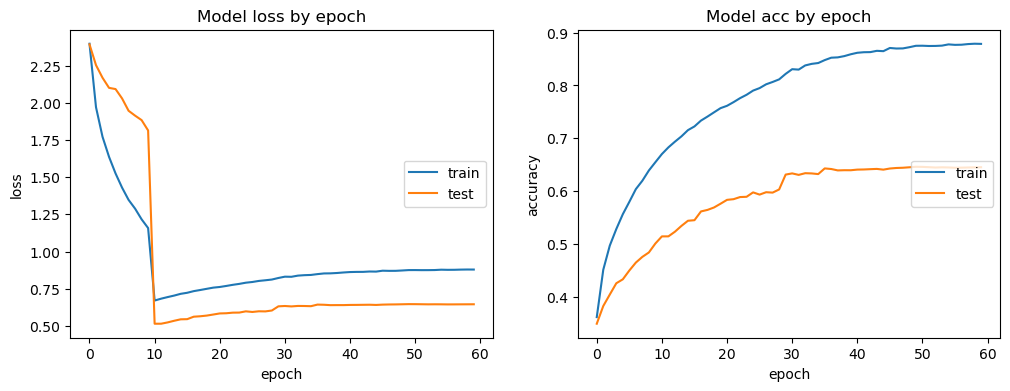

In [30]:



plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

   

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [31]:

#=========================================================================
dfp=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+'df_predict_EfficientNetB1_V04_DeFreeze.csv')
dfs=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+'sampling_strategy_B1_V04.csv')
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

FileNotFoundError: [Errno 2] No such file or directory: 'E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/fichiers/df_predict_EfficientNetB1_V04_DeFreeze.csv'

In [27]:
CNN="CNN31"
PGM="Model_Img_Reseau_RGB_EfficientNetB1_V01_4"
LIBBELLE="EfficientNetB1 5000-2000 SIZE400 DEFREEZE  DR40-CC1024-CC1024-DR40"

In [28]:
df_val_accuracy= pd.read_csv('df_val_accuracy60.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(val_acc)[:60],index=np.arange(1 , 61, 1),columns =['val_accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] !=CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
#df_val_accuracy=df_val_accuracy2.copy()
df_val_accuracy.to_csv('df_val_accuracy60.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  val_accuracy                                programme  \
0      1      0.017904  Model_Img_Reseau_RGB_EfficientNetB5_V02   
1      2      0.037630  Model_Img_Reseau_RGB_EfficientNetB5_V02   
2      3      0.067094  Model_Img_Reseau_RGB_EfficientNetB5_V02   
3      4      0.122943  Model_Img_Reseau_RGB_EfficientNetB5_V02   
4      5      0.145496  Model_Img_Reseau_RGB_EfficientNetB5_V02   

                                             libelle     id  
0  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
1  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
2  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
3  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
4  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
*******************
    Epoch  val_accuracy                                programme  \
55     56      0.636198  Model_Img_Reseau_RGB_EfficientNetB5_V02   
56     57      0.644553  Model_Img_Reseau_RGB_EfficientNetB5_V02   
5

In [29]:
df_val_accuracy= pd.read_csv('df_accuracy60.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(train_acc)[:60],index=np.arange(1 , 61, 1),columns =['accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] != CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
#df_val_accuracy=df_val_accuracy2.copy()
df_val_accuracy.to_csv('df_accuracy60.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  accuracy                                programme  \
0      1  0.475163  Model_Img_Reseau_RGB_EfficientNetB5_V02   
1      2  0.546991  Model_Img_Reseau_RGB_EfficientNetB5_V02   
2      3  0.586463  Model_Img_Reseau_RGB_EfficientNetB5_V02   
3      4  0.615585  Model_Img_Reseau_RGB_EfficientNetB5_V02   
4      5  0.637658  Model_Img_Reseau_RGB_EfficientNetB5_V02   

                                             libelle     id  
0  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
1  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
2  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
3  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
4  EfficientNetB5 5000-2000 SIZE400 DEFREEZE  DR4...  CNN30  
*******************
   accuracy
1  0.360101
2  0.451026
3  0.492862
4  0.530025
5  0.557164
*******************
   Epoch  accuracy                                programme  \
0      1  0.475163  Model_Img_Reseau_RGB_EfficientNetB5_V02   
1      2  0

In [30]:
"""
with open('E:\\Manuel\\PROJET\\fichiers\\train_acc_EfficientNet_V1_DeFreeze.pkl', 'rb') as f:
    train_acc = pickle.load(f)
with open('E:\\Manuel\\PROJET\\fichiers\\val_acc_EfficientNet_V1_DeFreeze.pkl', 'rb') as f:
    val_acc = pickle.load(f)
model.load_weights('E:\\Manuel\\PROJET\\fichiers\\WEfficientNetB1_weights_V1.h5')    
"""


In [34]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_orinal2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_orinal2)))

Précision de la prédiction: 64.90765171503958 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.50      0.47      0.49       623
          40       0.75      0.41      0.53       502
          50       0.58      0.44      0.50       336
          60       0.83      0.69      0.76       166
        1140       0.69      0.69      0.69       534
        1160       0.90      0.95      0.93       791
        1180       0.53      0.40      0.45       153
        1280       0.51      0.41      0.45       974
        1281       0.36      0.28      0.31       414
        1300       0.65      0.83      0.73      1000
        1301       0.78      0.72      0.75       161
        1302       0.57      0.52      0.54       498
        1320       0.63      0.56      0.59       648
        1560       0.55      0.65      0.60      1000
        1920       0.83      0.83      0.83       861
        1940       0.58      0.7

In [35]:
df_report= pd.read_csv('df_report60.csv')
df_report.head()

report_dict = classification_report(y_test_original2, test_pred_orinal2, output_dict=True)

# Conversion du rapport de classification en DataFrame
df_report2 = pd.DataFrame(report_dict).transpose()
df_report2['programme']=PGM
df_report2['libelle']=LIBBELLE
df_report2['id']=CNN
df_report2.reset_index(inplace=True)
df_report2 = df_report2.rename(columns={"index": "Categorie"})
df_report=df_report[df_report['id'] != CNN]
df_report = pd.concat([df_report,df_report2])
df_report.drop('Unnamed: 0',axis=1,inplace=True)
#df_report=df_report2.copy()
df_report.to_csv('df_report60.csv')
df_report.tail(50)

,Categorie,precision,recall,f1-score,support,programme,libelle,id
10,1301,0.296629,0.819876,0.435644,161.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
11,1302,0.657051,0.411647,0.506173,498.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
12,1320,0.735897,0.442901,0.552987,648.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
13,1560,0.670563,0.631000,0.650180,1000.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
14,1920,0.838303,0.849013,0.843624,861.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
15,1940,0.299127,0.850932,0.442649,161.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
16,2060,0.641414,0.508509,0.567281,999.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
17,2220,0.135632,0.715152,0.228019,165.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
18,2280,0.767040,0.792017,0.779328,952.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30
19,2403,0.757497,0.608377,0.674797,955.000000,Model_Img_Reseau_RGB_EfficientNetB5_V02,EfficientNetB5 5000-2000 SIZE400 DEFREEZE DR4...,CNN30


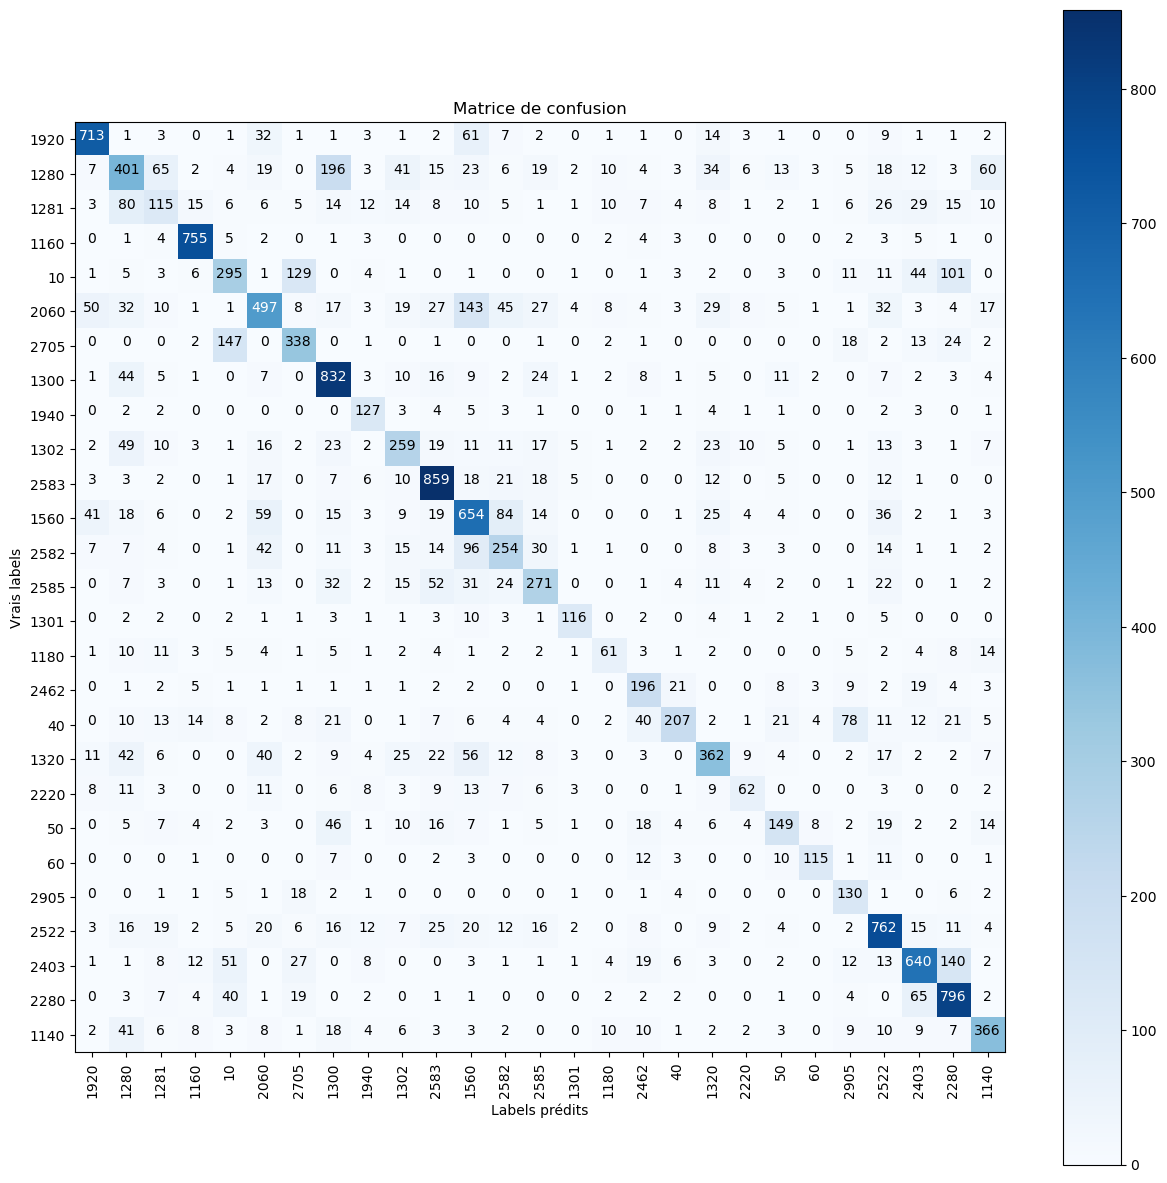

In [36]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test_original2, test_pred_orinal2,labels=list(set(y_test_original2)))
#print(cnf_matrix)

###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
#classes = [10,2280,2403,2705,40,50,2462,1280,1281]
classes=list(set(y_test_original2))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


In [38]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_orinal2})
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.473515,0.004815,0.004815,0.000000,0.000000,0.009631,0.000000,0.008026,0.004815,0.000000,...,0.000000,0.162119,0.070626,0.001605,0.017657,0.000000,0.000000,0.000000,0.207063,0.017657
40,0.015936,0.412351,0.041833,0.007968,0.009960,0.027888,0.003984,0.019920,0.025896,0.041833,...,0.001992,0.041833,0.023904,0.079681,0.021912,0.007968,0.013944,0.007968,0.015936,0.155378
50,0.005952,0.011905,0.443452,0.023810,0.041667,0.011905,0.000000,0.014881,0.020833,0.136905,...,0.011905,0.005952,0.005952,0.053571,0.056548,0.002976,0.047619,0.014881,0.000000,0.005952
60,0.000000,0.018072,0.060241,0.692771,0.006024,0.006024,0.000000,0.000000,0.000000,0.042169,...,0.000000,0.000000,0.000000,0.072289,0.066265,0.000000,0.012048,0.000000,0.000000,0.006024
1140,0.005618,0.001873,0.005618,0.000000,0.685393,0.014981,0.018727,0.076779,0.011236,0.033708,...,0.003745,0.013109,0.016854,0.018727,0.018727,0.003745,0.005618,0.000000,0.001873,0.016854
1160,0.006321,0.003793,0.000000,0.000000,0.000000,0.954488,0.002528,0.001264,0.005057,0.001264,...,0.000000,0.001264,0.006321,0.005057,0.003793,0.000000,0.000000,0.000000,0.000000,0.002528
1180,0.032680,0.006536,0.000000,0.000000,0.091503,0.019608,0.398693,0.065359,0.071895,0.032680,...,0.000000,0.052288,0.026144,0.019608,0.013072,0.013072,0.026144,0.013072,0.006536,0.032680
1280,0.004107,0.003080,0.013347,0.003080,0.061602,0.002053,0.010267,0.411704,0.066735,0.201232,...,0.006160,0.003080,0.012320,0.004107,0.018480,0.006160,0.015400,0.019507,0.000000,0.005133
1281,0.014493,0.009662,0.004831,0.002415,0.024155,0.036232,0.024155,0.193237,0.277778,0.033816,...,0.002415,0.036232,0.070048,0.016908,0.062802,0.012077,0.019324,0.002415,0.012077,0.014493


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(base_model) # Ajout du modèle  EfficientNetB1
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(27, activation='softmax'))
model.summary()

In [29]:
y_test_original = np.argmax(y_test_Network, axis=1)
#print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)

predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_orinal2=label_encoder.inverse_transform(y_pred)

top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_orinal2})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

df_pred = pd.DataFrame()
for c in Lcat:
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    
df_pred.to_csv('df_predict.csv')

499/499 [==============================] - 164s 326ms/step


In [36]:
training_history = model.fit(dataset_train, epochs=5, validation_data = dataset_test, callbacks=[lr_plateau])

model.save_weights('E:\\Manuel\\PROJET\\fichiers\\WEfficientNetB1_weights_3.h5')


train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

with open('E:\\Manuel\\PROJET\\fichiers\\train_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(train_acc, f)
with open('E:\\Manuel\\PROJET\\fichiers\\val_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(val_acc, f)
    
y_test_original = np.argmax(y_test_Network, axis=1)
#print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)

predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_orinal2=label_encoder.inverse_transform(y_pred)

top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_orinal2})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

df_pred = pd.DataFrame()
for c in Lcat:
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    
df_pred.to_csv('df_predict.csv')





Epoch 1/5
2078/2078 [==============================] - 530s 255ms/step - loss: 1.4452 - accuracy: 0.5640 - val_loss: 1.3509 - val_accuracy: 0.5932 - lr: 1.0000e-05
Epoch 2/5
2078/2078 [==============================] - 526s 253ms/step - loss: 1.4144 - accuracy: 0.5729 - val_loss: 1.3354 - val_accuracy: 0.5979 - lr: 1.0000e-05
Epoch 3/5
2078/2078 [==============================] - 526s 253ms/step - loss: 1.4011 - accuracy: 0.5785 - val_loss: 1.3227 - val_accuracy: 0.6008 - lr: 1.0000e-05
Epoch 4/5
2078/2078 [==============================] - 527s 254ms/step - loss: 1.3794 - accuracy: 0.5819 - val_loss: 1.3100 - val_accuracy: 0.6042 - lr: 1.0000e-05
Epoch 5/5
520/520 [==============================] - 100s 193ms/step


In [37]:
#=========================================================================
dfp=pd.read_csv('df_predict_V1.csv')
dfs=pd.read_csv('sampling_strategy.csv')
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,2583,6000,2583,0.813333,2522,0.027500,1560,0.024167
1,1560,5073,1560,0.580296,2060,0.119212,1920,0.057143
2,1300,5045,1300,0.793855,2583,0.034688,2522,0.023786
3,2060,4993,2060,0.591592,1920,0.066066,1560,0.051051
4,2522,4989,2522,0.718437,2583,0.044088,2060,0.030060
5,1280,4870,1280,0.398357,1300,0.175565,1140,0.095483
6,2403,4774,2403,0.615707,2280,0.149738,10,0.087958
7,2280,4760,2280,0.759454,2403,0.088235,10,0.055672
8,1920,4303,1920,0.838560,2060,0.049942,1560,0.030197
9,1160,3953,1160,0.916561,2403,0.022756,2280,0.015171


In [ ]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_orinal2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_orinal2)))


In [ ]:
### SAUVEGARDE DU MODELE

In [51]:
#model.save('E:\\Manuel\\PROJET\\fichiers\\EfficientNetB1')
model.save_weights('E:\\Manuel\\PROJET\\fichiers\\WEfficientNetB1_weights.h5')

###  RECUPERER  LE MODELE

In [55]:
from tensorflow.keras.models import load_model

model.load_weights('E:\\Manuel\\PROJET\\fichiers\\WEfficientNetB1_weights_1.h5')

In [28]:
import pickle
with open('E:\\Manuel\\PROJET\\fichiers\\train_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(train_acc, f)
with open('E:\\Manuel\\PROJET\\fichiers\\val_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(val_acc, f)

In [ ]:
from joblib import dump
dump(model, 'E:\\Manuel\\PROJET\\fichiers\\EfficientNetB1.joblib')



['/content/drive/MyDrive/Colab_Notebooks/Rakuten/fichiers/EfficientNetB1.joblib']

In [35]:
with open('E:\\Manuel\\PROJET\\fichiers\\train_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(train_acc, f)
with open('E:\\Manuel\\PROJET\\fichiers\\val_acc_EfficientNet.pkl', 'wb') as f:
    pickle.dump(val_acc, f)

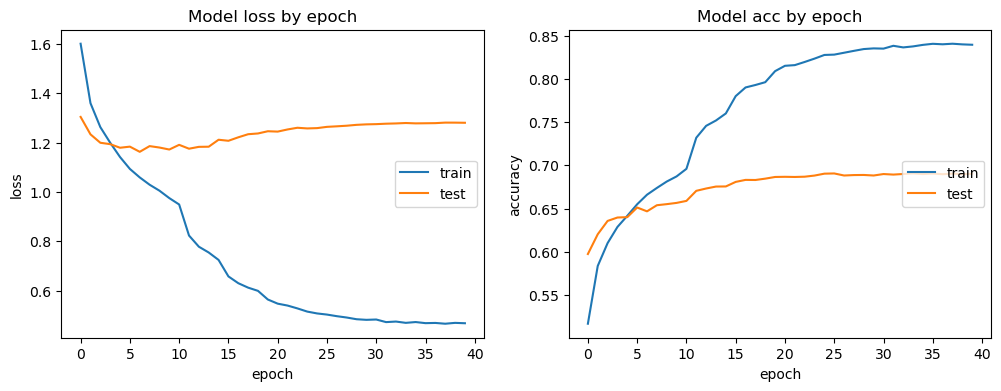

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [27]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']


In [26]:
CNN="CNN22"
PGM="Model_Img_Reseau_RGB_EfficientNetB1_V01_2"
LIBBELLE="EfficientNetB1 5000-2000 SIZE400 DeFreeze  DR40-CC1024-CC1024-DR40"

In [31]:
df_val_accuracy= pd.read_csv('df_val_accuracy.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(val_acc)[:40],index=np.arange(1 , 41, 1),columns =['val_accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] != CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
df_val_accuracy.to_csv('df_val_accuracy.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  val_accuracy                               programme  \
0      1      0.181025  Modele_IMG_Reseau_images_undersampling   
1      2      0.214916  Modele_IMG_Reseau_images_undersampling   
2      3      0.211974  Modele_IMG_Reseau_images_undersampling   
3      4      0.223237  Modele_IMG_Reseau_images_undersampling   
4      5      0.230238  Modele_IMG_Reseau_images_undersampling   

                  libelle       id  
0  undersampling max 2400  UNDER01  
1  undersampling max 2400  UNDER01  
2  undersampling max 2400  UNDER01  
3  undersampling max 2400  UNDER01  
4  undersampling max 2400  UNDER01  
*******************
     Epoch  val_accuracy                                  programme  \
755     36      0.623760  Model_Img_Reseau_RGB_EfficientNetB1_V01_2   
756     37      0.613007  Model_Img_Reseau_RGB_EfficientNetB1_V01_2   
757     38      0.612750  Model_Img_Reseau_RGB_EfficientNetB1_V01_2   
758     39      0.621829  Model_Img_Reseau_RGB_EfficientNetB1_V01_2   
759   

In [32]:
df_val_accuracy= pd.read_csv('df_accuracy.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(train_acc)[:40],index=np.arange(1 , 41, 1),columns =['accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] != CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
df_val_accuracy.to_csv('df_accuracy.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  accuracy                               programme  \
0      1  0.139686  Modele_IMG_Reseau_images_undersampling   
1      2  0.186874  Modele_IMG_Reseau_images_undersampling   
2      3  0.205952  Modele_IMG_Reseau_images_undersampling   
3      4  0.220996  Modele_IMG_Reseau_images_undersampling   
4      5  0.234594  Modele_IMG_Reseau_images_undersampling   

                  libelle       id  
0  undersampling max 2400  UNDER01  
1  undersampling max 2400  UNDER01  
2  undersampling max 2400  UNDER01  
3  undersampling max 2400  UNDER01  
4  undersampling max 2400  UNDER01  
*******************
   accuracy
1  0.488756
2  0.588303
3  0.639916
4  0.681213
5  0.713210
*******************
   Epoch  accuracy                               programme  \
0      1  0.139686  Modele_IMG_Reseau_images_undersampling   
1      2  0.186874  Modele_IMG_Reseau_images_undersampling   
2      3  0.205952  Modele_IMG_Reseau_images_undersampling   
3      4  0.220996  Modele_IMG_Reseau_images_

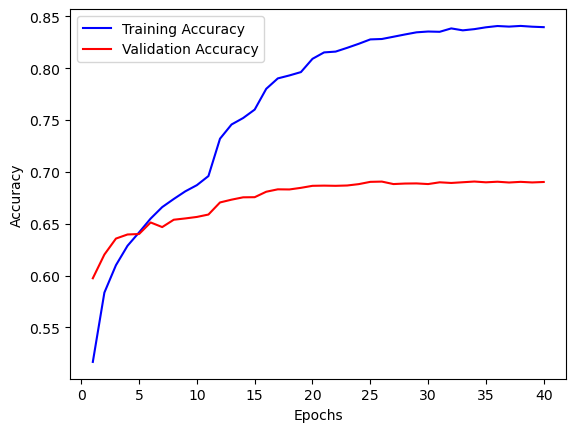

In [33]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 41, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 ,41, 1),
         training_history.history['val_accuracy'],
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()


In [33]:
y_test_original = np.argmax(y_test_Network, axis=1)
print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)
y_test_original2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]


array([2462, 2583, 1160, ..., 2220,   40, 2583], dtype=int64)

In [34]:
predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_orinal2=label_encoder.inverse_transform(y_pred)
test_pred_orinal2


486/486 [==============================] - 104s 203ms/step


array([2462, 1940, 1160, ..., 2220,   40, 2583], dtype=int64)

In [35]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_orinal2})
#print(top5_df.info())
#print(top5_df.head(5))

for c in Lcat:
    print(c,'   ------   ', catdict[c] )    
    print(top5_df[top5_df['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])   

10    ------    livres
10      0.844302
2905    0.067416
2280    0.022472
2403    0.016051
1940    0.016051
Name: predict, dtype: float64
40    ------    jeux video pour pc et consoles
40      0.597610
2462    0.205179
2905    0.085657
50      0.019920
1940    0.015936
Name: predict, dtype: float64
50    ------     accesoires jeux video
50      0.857143
60      0.065476
2462    0.026786
1300    0.011905
2220    0.008929
Name: predict, dtype: float64
60    ------    consoles de jeux video
60      0.96988
2462    0.03012
Name: predict, dtype: float64
1140    ------    produits derives “geeks” et figurines
1140    0.812734
1180    0.071161
2462    0.037453
2905    0.016854
2220    0.016854
Name: predict, dtype: float64
1160    ------    cartes collectionables
1160    0.964602
2462    0.024020
2905    0.002528
1180    0.002528
2705    0.001264
Name: predict, dtype: float64
1180    ------    figurines collectionables pour jeux de societe
1180    0.941176
2905    0.019608
2462    0.013072
20

In [36]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test, test_pred_orinal2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test, test_pred_orinal2)))


Précision de la prédiction: 86.87701223438506 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.91      0.84      0.88       623
          40       0.97      0.60      0.74       502
          50       0.83      0.86      0.84       336
          60       0.71      0.97      0.82       166
        1140       0.92      0.81      0.86       534
        1160       0.99      0.96      0.98       791
        1180       0.54      0.94      0.68       153
        1280       0.92      0.63      0.75      1000
        1300       0.91      0.90      0.91      1000
        1301       0.67      0.96      0.79       161
        1302       0.93      0.87      0.90       498
        1320       0.95      0.83      0.88       648
        1560       0.93      0.90      0.91      1000
        1920       0.96      0.96      0.96       861
        1940       0.52      0.99      0.68       161
        2060       0.92      0.8

In [37]:
CNN="CNN25"
PGM="Model_Img_Reseau_RGB_EfficientNetB1_V01"
LIBBELLE="EfficientNetB1 max5000 mIN2000 SIZE400  DR40-CC1024-CC1024-DR40"

In [38]:
df_report= pd.read_csv('df_report.csv')
df_report.head()

report_dict = classification_report(y_test, test_pred_orinal2, output_dict=True)

# Conversion du rapport de classification en DataFrame
df_report2 = pd.DataFrame(report_dict).transpose()
df_report2['programme']=PGM
df_report2['libelle']=LIBBELLE
df_report2['id']=CNN
df_report2.reset_index(inplace=True)
df_report2 = df_report2.rename(columns={"index": "Categorie"})
df_report=df_report[df_report['id'] != CNN]
df_report = pd.concat([df_report,df_report2])
df_report.drop('Unnamed: 0',axis=1,inplace=True)
df_report.to_csv('df_report.csv')
df_report.tail(50)

,Categorie,precision,recall,f1-score,support,programme,libelle,id
517,1300,0.682759,0.784936,0.730290,1009.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
518,1301,0.761006,0.751553,0.756250,161.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
519,1302,0.571739,0.528112,0.549061,498.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
520,1320,0.586885,0.552469,0.569157,648.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
521,1560,0.648016,0.627586,0.637638,1015.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
522,1920,0.824639,0.862950,0.843360,861.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
523,1940,0.707182,0.795031,0.748538,161.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
524,2060,0.576389,0.581582,0.578974,999.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
525,2220,0.616667,0.448485,0.519298,165.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23
526,2280,0.751479,0.800420,0.775178,952.000000,Model_Img_Reseau_RGB_EfficientNetB1_V02,EfficientNetB1 max6000 SIZE400 FLIP DR40-CC102...,CNN23


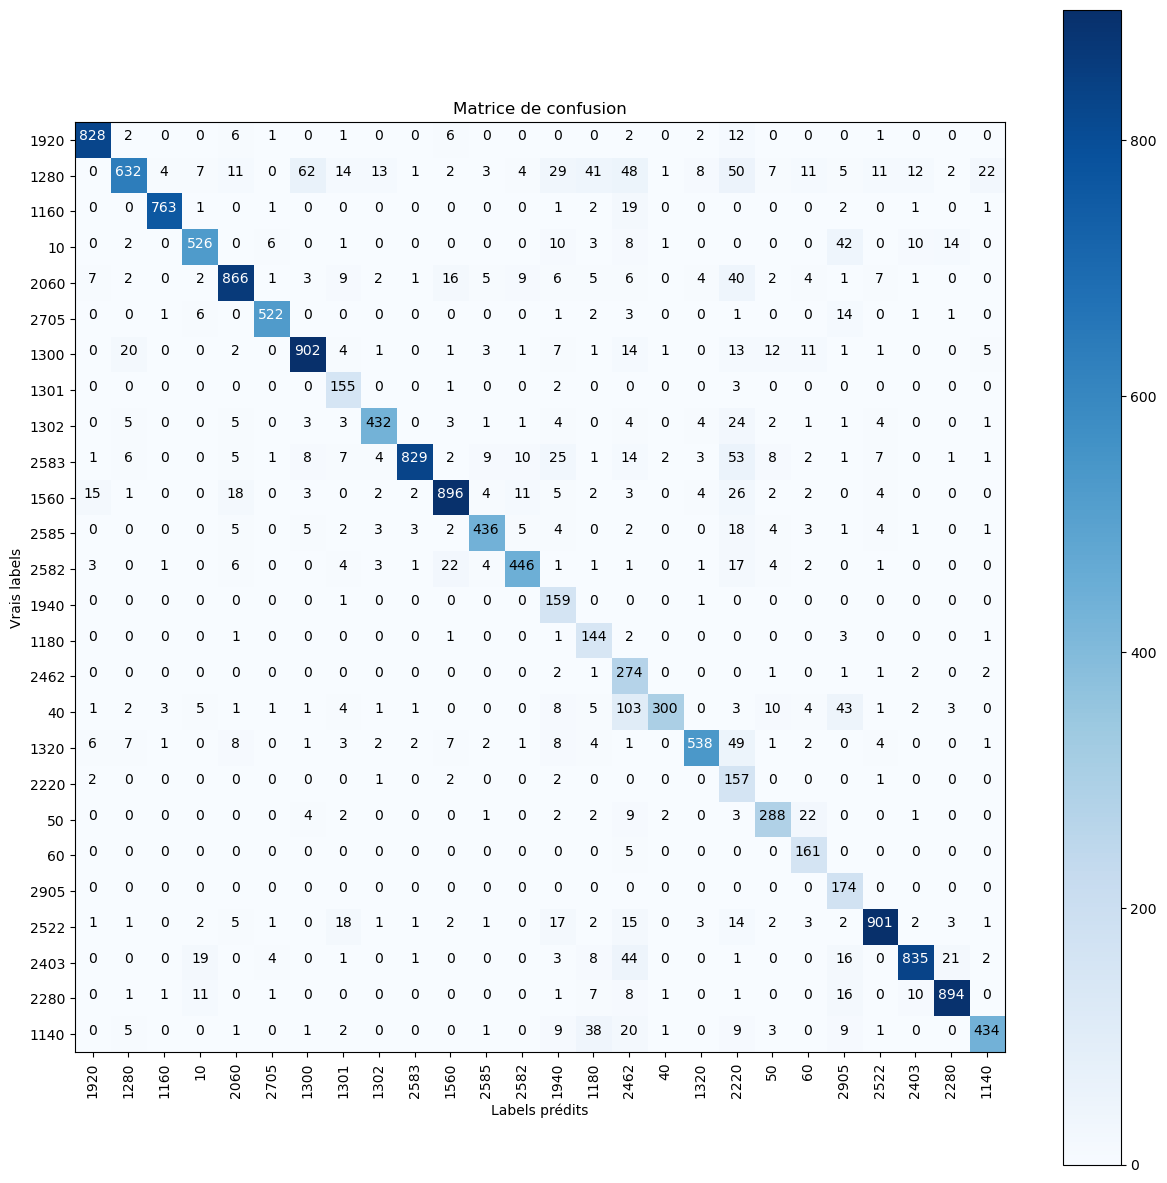

In [39]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test, test_pred_orinal2,labels=list(set(y_test_original2)))
#print(cnf_matrix)

###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
#classes = [10,2280,2403,2705,40,50,2462,1280,1281]
classes=list(set(y_test_original2))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

#####

In [40]:
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1300,1301,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.844302,0.001605,0.000000,0.000000,0.000000,0.000000,0.004815,0.003210,0.000000,0.001605,...,0.000000,0.022472,0.016051,0.012841,0.000000,0.000000,0.000000,0.000000,0.009631,0.067416
40,0.009960,0.597610,0.019920,0.007968,0.000000,0.005976,0.009960,0.003984,0.001992,0.007968,...,0.005976,0.005976,0.003984,0.205179,0.001992,0.000000,0.001992,0.000000,0.001992,0.085657
50,0.000000,0.005952,0.857143,0.065476,0.000000,0.000000,0.005952,0.000000,0.011905,0.005952,...,0.008929,0.000000,0.002976,0.026786,0.000000,0.000000,0.000000,0.002976,0.000000,0.000000
60,0.000000,0.000000,0.000000,0.969880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.030120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.000000,0.001873,0.005618,0.000000,0.812734,0.000000,0.071161,0.009363,0.001873,0.003745,...,0.016854,0.000000,0.000000,0.037453,0.001873,0.000000,0.000000,0.001873,0.000000,0.016854
1160,0.001264,0.000000,0.000000,0.000000,0.001264,0.964602,0.002528,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001264,0.024020,0.000000,0.000000,0.000000,0.000000,0.001264,0.002528
1180,0.000000,0.000000,0.000000,0.000000,0.006536,0.000000,0.941176,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.013072,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608
1280,0.007000,0.001000,0.007000,0.011000,0.022000,0.004000,0.041000,0.632000,0.062000,0.014000,...,0.050000,0.002000,0.012000,0.048000,0.011000,0.004000,0.001000,0.003000,0.000000,0.005000
1300,0.000000,0.001000,0.012000,0.011000,0.005000,0.000000,0.001000,0.020000,0.902000,0.004000,...,0.013000,0.000000,0.000000,0.014000,0.001000,0.001000,0.000000,0.003000,0.000000,0.001000


In [41]:
s=df_cross.loc[2905].sort_values(ascending=False)[:5]
print(s)
print("////////////")
print(s.index[0],s.iloc[0])
print(s.values[0],s.iloc[0])

predict
2905    1.0
40      0.0
2705    0.0
2585    0.0
2583    0.0
Name: 2905, dtype: float64
////////////
2905 1.0
1.0 1.0


In [42]:
df_pred = pd.DataFrame()
for c in Lcat:
    print(c, '   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    for index, value in s.items():  # Change ici
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")
df_pred.to_csv('df_predict.csv')

10    ------    livres
  : 10,  : 84.43 % , livres
  : 2905,  : 6.74 % , Jeu En téléchargement
  : 2280,  : 2.25 % , magazines
  : 1940,  : 1.61 % , nouriture (cafes,infusions,conserves, epices,etc)
  : 2403,  : 1.61 % , livres et bds
40    ------    jeux video pour pc et consoles
  : 40,  : 59.76 % , jeux video pour pc et consoles
  : 2462,  : 20.52 % , consoles de jeux video et jeux videos
  : 2905,  : 8.57 % , Jeu En téléchargement
  : 50,  : 1.99 % ,  accesoires jeux video
  : 1940,  : 1.59 % , nouriture (cafes,infusions,conserves, epices,etc)
50    ------     accesoires jeux video
  : 50,  : 85.71 % ,  accesoires jeux video
  : 60,  : 6.55 % , consoles de jeux video
  : 2462,  : 2.68 % , consoles de jeux video et jeux videos
  : 1300,  : 1.19 % , Petites voitures (jouets) et maquettes
  : 2220,  : 0.89 % , accesoires mascots/pets
60    ------    consoles de jeux video
  : 60,  : 96.99 % , consoles de jeux video
  : 2462,  : 3.01 % , consoles de jeux video et jeux videos
  : 10,  :

In [46]:
dfp=pd.read_csv('df_predict.csv')
dfs=pd.read_csv('sampling_strategy.csv')
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,2583,6000,2583,0.867500,2585,0.024167,2060,0.015833
1,1280,6000,1280,0.516667,1300,0.133333,1140,0.052500
2,1560,5073,1560,0.634483,2060,0.095567,2582,0.057143
3,1300,5045,1300,0.830525,1280,0.059465,50,0.024777
4,2060,4993,2060,0.566567,1560,0.083083,1920,0.064064
5,2522,4989,2522,0.739479,1280,0.031062,2403,0.029058
6,2403,4774,2403,0.687958,2280,0.116230,10,0.092147
7,2280,4760,2280,0.772059,2403,0.088235,10,0.081933
8,1920,4303,1920,0.831591,2060,0.042973,1560,0.037166
9,1160,3953,1160,0.931732,40,0.013906,1280,0.011378


In [46]:
df_pred.tail()

,Categorie,predict,pourc,predict2,pourc2,predict3,pourc3
21,2582,1560,0.345560,2583,0.156371,2060,0.133205
22,2583,2583,0.665000,2522,0.106250,1300,0.075000
23,2585,1300,0.264529,2583,0.218437,2522,0.204409
24,2705,2705,0.722826,2280,0.135870,10,0.085145
25,2905,40,0.339080,2705,0.298851,2280,0.212644


# ADAM effecient:  
Epoch 1/10
1687/1687 [==============================] - 209s 119ms/step - loss: 3.2375 - accuracy: 0.0441 - val_loss: 3.2288 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 2/10
1687/1687 [==============================] - 200s 118ms/step - loss: 3.2281 - accuracy: 0.0440 - val_loss: 3.2286 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 3/10
1687/1687 [==============================] - 200s 118ms/step - loss: 3.2279 - accuracy: 0.0442 - val_loss: 3.2283 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 4/10
1687/1687 [==============================] - 199s 118ms/step - loss: 3.2277 - accuracy: 0.0433 - val_loss: 3.2280 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 5/10
1687/1687 [==============================] - 203s 120ms/step - loss: 3.2274 - accuracy: 0.0432 - val_loss: 3.2279 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 6/10
1687/1687 [==============================] - 202s 120ms/step - loss: 3.2271 - accuracy: 0.0444 - val_loss: 3.2275 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 7/10
1687/1687 [==============================] - 200s 119ms/step - loss: 3.2271 - accuracy: 0.0439 - val_loss: 3.2274 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 8/10
1687/1687 [==============================] - 200s 119ms/step - loss: 3.2269 - accuracy: 0.0445 - val_loss: 3.2272 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 9/10
1687/1687 [==============================] - 201s 119ms/step - loss: 3.2270 - accuracy: 0.0436 - val_loss: 3.2271 - val_accuracy: 0.0454 - lr: 0.0010
Epoch 10/10
1687/1687 [==============================] - 202s 120ms/step - loss: 3.2269 - accuracy: 0.0445 - val_loss: 3.2275 - val_accuracy: 0.0454 - lr: 0.0010
<keras.callbacks.History at 0x27443722fa0>


In [ ]:
classes

[1280,
 1281,
 1920,
 1160,
 10,
 2060,
 2705,
 1940,
 1301,
 2582,
 1302,
 1560,
 2585,
 1300,
 2583,
 1180,
 2462,
 1320,
 40,
 2220,
 50,
 60,
 2905,
 2522,
 2403,
 2280,
 1140]

# FIN

In [ ]:
import pickle

# Disons que vous avez une liste d'images


# Pour enregistrer la liste :
with open('E:\\Manuel\\PROJET\\pickle\\df_img_X.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('E:\\Manuel\\PROJET\\pickle\\df_img_y.pkl', 'wb') as f:
    pickle.dump(y, f)


In [ ]:
import pickle
with open('E:\\Manuel\\PROJET\\pickle\\df_img_X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('E:\\Manuel\\PROJET\\pickle\\df_img_y.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
dsize = (250,250)
X_Reshape=[]
for im in X:
    X_Reshape.append(im.reshape([-1,250*250*3]).flatten())
del X,im
gc.collect()

0

In [ ]:
import pickle


with open('E:\\Manuel\\PROJET\\pickle\\df_img_X_Reshape.pkl', 'wb') as f:
    pickle.dump(X_Reshape, f)


In [ ]:
import pickle

with open('E:\\Manuel\\PROJET\\pickle\\df_img_X_Reshape.pkl', 'rb') as f:
    X_Reshape = pickle.load(f)
with open('E:\\Manuel\\PROJET\\pickle\\df_img_y.pkl', 'rb') as f:
    y = pickle.load(f)
print(len(X_Reshape))
print(len(X_Reshape[0]))
X_Reshape[0]

27961
187500


array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [ ]:
y_serie =pd.Series(y).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

1280


1280    4870
2403    4774
2280    4760
10      3116
2705    2761
40      2508
1281    2070
50      1681
2462    1421
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Reshape, y, test_size=0.20, random_state=20,stratify=y)

In [ ]:
del X_Reshape,y
gc.collect()

0

In [ ]:
X_train =  np.array(X_train)
X_train = X_train.astype('float32')
X_train =  X_train / 255

X_test = np.array(X_test) / 255
X_test = X_test.astype('float32')


In [ ]:
model = RandomForestClassifier(n_jobs=-1)

print(X_train[0].shape)
print(len(X_train))
print(len(y_train))
print(X_train[0])
print(y_train[0])
# Entraînement du modèle
model.fit(X_train, y_train);


(187500,)
22368
22368
[1. 1. 1. ... 1. 1. 1.]
2280


In [ ]:
# Prédiction sur l'échantillon de test
test_pred = model.predict(X_test)

# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test, test_pred)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test, test_pred)))


Précision de la prédiction: 57.500446987305565 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.55      0.56      0.55       624
          40       0.52      0.35      0.41       502
          50       0.57      0.29      0.39       336
        1280       0.52      0.77      0.62       974
        1281       0.39      0.07      0.12       414
        2280       0.63      0.69      0.66       952
        2403       0.52      0.67      0.59       955
        2462       0.63      0.17      0.27       284
        2705       0.82      0.85      0.84       552

    accuracy                           0.58      5593
   macro avg       0.57      0.49      0.49      5593
weighted avg       0.57      0.58      0.55      5593



## SAUVEGARDE DU MODELE

In [ ]:
from joblib import dump
dump(model, 'RandomForestClassifierClassifier.joblib')

['RandomForestClassifierClassifier.joblib']

[[347  27   4  54   3 104  71   2  12]
 [ 40 174  31 125  10  48  48   4  22]
 [  8  19  99 158   9  10  24   5   4]
 [ 26  20  15 750  17  26 110   1   9]
 [ 17  20  11 223  29  27  77   1   9]
 [ 80  27   1  32   1 655 121   3  32]
 [ 80  16   3  60   3 127 642  12  12]
 [ 10  27   9  30   3  14 138  49   4]
 [ 23   7   2  23   0  21   4   1 471]]


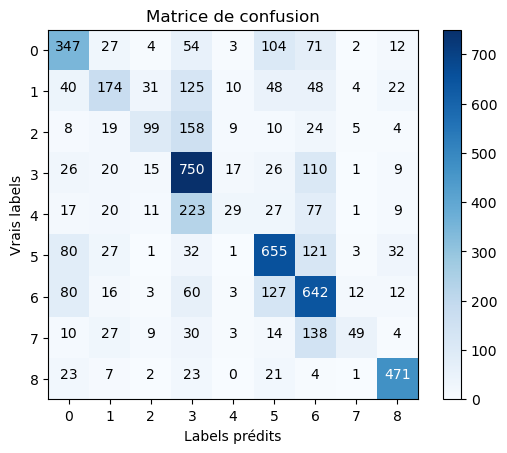

Le chiffre 0 a souvent été pris pour le chiffre 1
Le chiffre 0 a souvent été pris pour le chiffre 3
Le chiffre 0 a souvent été pris pour le chiffre 5
Le chiffre 0 a souvent été pris pour le chiffre 6
Le chiffre 1 a souvent été pris pour le chiffre 0
Le chiffre 1 a souvent été pris pour le chiffre 2
Le chiffre 1 a souvent été pris pour le chiffre 3
Le chiffre 1 a souvent été pris pour le chiffre 5
Le chiffre 1 a souvent été pris pour le chiffre 6
Le chiffre 1 a souvent été pris pour le chiffre 8
Le chiffre 2 a souvent été pris pour le chiffre 1
Le chiffre 2 a souvent été pris pour le chiffre 3
Le chiffre 2 a souvent été pris pour le chiffre 6
Le chiffre 3 a souvent été pris pour le chiffre 0
Le chiffre 3 a souvent été pris pour le chiffre 1
Le chiffre 3 a souvent été pris pour le chiffre 4
Le chiffre 3 a souvent été pris pour le chiffre 5
Le chiffre 3 a souvent été pris pour le chiffre 6
Le chiffre 4 a souvent été pris pour le chiffre 0
Le chiffre 4 a souvent été pris pour le chiffre 1


In [ ]:
import itertools # Pour créer des itérateurs
cnf_matrix = confusion_matrix(y_test, test_pred)
print(cnf_matrix)

###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
classes = range(0,9)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

#####

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if(cnf_matrix[i,j] >15 and i!=j):
        print("Le chiffre {0} a souvent été pris pour le chiffre {1}".format(i,j))

